# Price and Company data for the S&P 500

# Overview

This DataSet came from kaggle.  To see a comprehensive overview 
visit: https://www.kaggle.com/dgawlik/nyse

It contains several files that have features suitable for both:

    - Technical Analysis (utilizing pricing data for a stock,,,to gauge the effects of supply-and-demand)
    - Fundamental Analysis (utilizing features that describe the health of the core business to gauge value)

For this analysis I will focus on the technical data from (2010-2016) contained within prices-split-adjusted.csv.  

# What's in our dataset ?

Firstly, let us load our prices-split-adjusted.csv into a Pandas DataFrame.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sps
import datetime
import matplotlib
%matplotlib inline

In [2]:
stocks_df = pd.read_csv('nyse/prices-split-adjusted.csv').sort_values(by=['date'])
stocks_df.head(1)

,date,symbol,open,close,low,high,volume
646,2010-01-04,SYMC,18.040001,18.4,18.01,18.530001,8322300.0


The relevant features here are the pricing columns (open, close, low, high) for the current day.  
The volume feature is the number of daily transactions for the stock.

Now that the data is loaded let's calculate the mean and standard deviation for a specific stock.
We will use Apple (AAPL) as our population sample

Once we've filtered out Apple's data we can use numpy to evaluate the mean and standard deviation.

In [3]:
stock_df = stocks_df[stocks_df['symbol'] == 'AMZN']
stock_df['close'].describe()

count    1762.000000
mean      337.899058
std       189.109339
min       108.610001
25%       193.377506
50%       282.915008
75%       398.014999
max       844.359985
Name: close, dtype: float64

Regarding Apple's Stock price highs for this period, we can say they have an average of \$80 and a standard deviation of \$29, But...

# Are Stock Prices a Normal Distribution ?

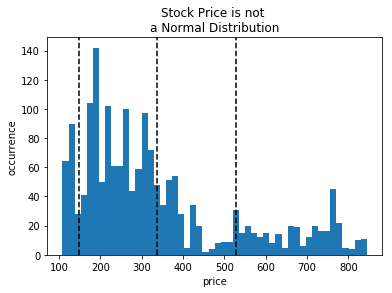

1762


In [4]:
plt.hist(stock_df['close'], 50)
plt.axvline(x=stock_df['close'].mean(),linestyle='dashed',color='black')
plt.axvline(x=stock_df['close'].mean()+stock_df['close'].std(),linestyle='dashed', color='black')
plt.axvline(x=stock_df['close'].mean()-stock_df['close'].std(),linestyle='dashed', color='black')
plt.xlabel('price')
plt.ylabel('occurrence')
plt.title('Stock Price is not \na Normal Distribution')
plt.show()
print(len(stock_df['close']))

As we can see from the chart, the mean and standard deviation markings coincide with our earlier calculations.  Since a normal-distrubtion contains 95% of the data within 2 - stddevs we can conclude that Stock Prices are not normally distributed

The distribution for Amazon above is log-normal distribution.  The right-skewness of the price means that the extreme prices for this stock occur less likely than the lower price quotes.

# Are Stock Prices highly-correlated with Volume ?

In [6]:
from scipy.stats import pearsonr
np.corrcoef(stock_df['high'], stock_df['volume'])
pearsonr(stock_df['high'], stock_df['volume'])

(-0.23336667190814706, 3.2005166196310365e-23)

### According to the Pearson test, a correlation value of -0.23 means a low, negative correlation  with a statistical significance because of the small pvalue (It was Not by chance)

To an investor this means great caution should be taken to put trading volume in the proper context.  

For example, if you an investor notices a rising price trend they can use volume data to determine if the trend is sustainable or not.  I have included a chart for price and volume below.  Notice the 10-day period starting on September 19th.  Here we have price increases that are supported by corresponding rise in volumes over that period.

When we see volume and pricing moving together an investor can have confidence that a trend can be sustained.

Yet their are situations where price movement is not backed up by volume.  On November 14th, price trends upwards yet the volume over that period was flat.  A cautious trader may choose not to trade during this volatile period unless he can find other indicators that can back up the trend.
    

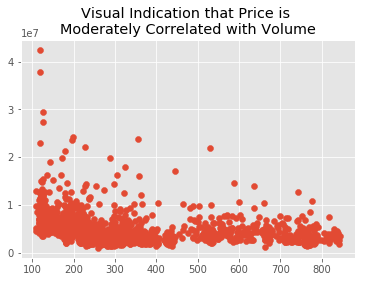

In [8]:
matplotlib.style.use('ggplot')
plt.scatter(stock_df['close'], stock_df['volume'])
plt.title('Visual Indication that Price is \nModerately Correlated with Volume')
plt.show()

Price and Volume are not highly-correlated.  Using the np.corrceof method we can see that Stock Prices and Volume are moderately (negative) correlated with each other. 

The scatterplot of the high-price and volume features shows that this conclusion visually.  Notice that the slope of line of best fit is negative and that the clustering of the values is loosley coupled.

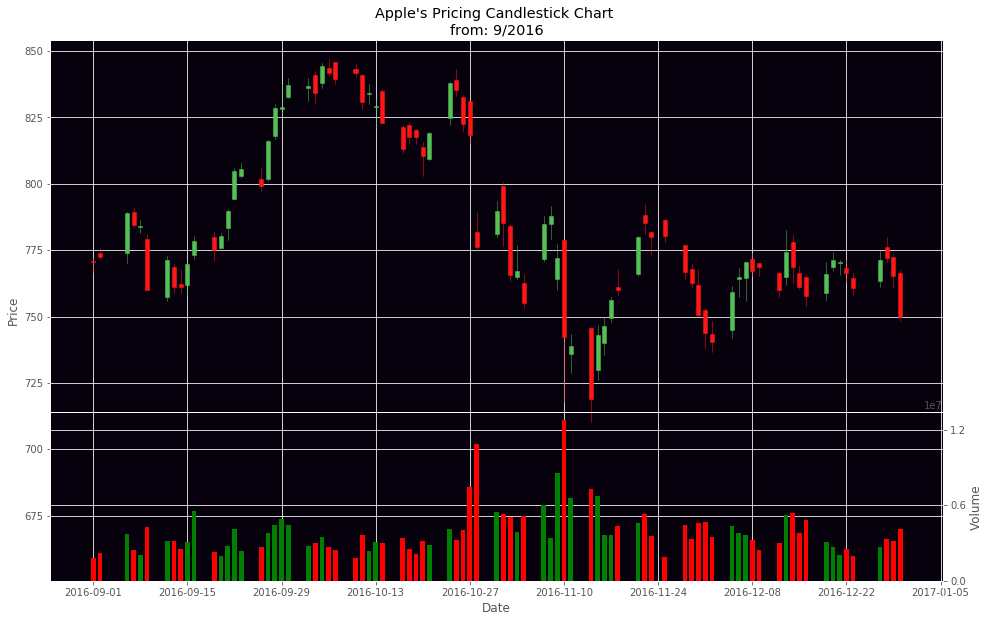

In [16]:
chart_price_and_volume('AMZN')

# How do the other features in the pricing dataset correlate with volume ?

# How does AAPL compare with other stocks ?

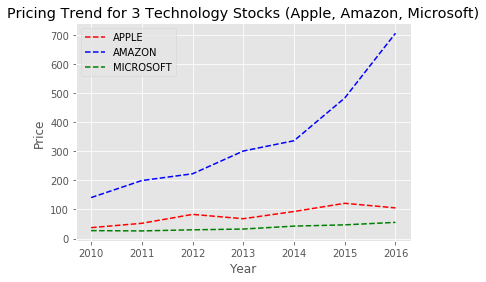

In [15]:
pd.options.mode.chained_assignment = None
stocks_df['date'] = pd.to_datetime(stocks_df['date'])
stocks_df['year'] = stocks_df['date'].dt.year
stocks_df['month'] = stocks_df['date'].dt.month
stocks_df['day'] = stocks_df['date'].dt.day

grouped_by_df = pd.pivot_table(stocks_df, index = ['symbol','year'], values= "high")
fig, ax = plt.subplots()
plt.plot(grouped_by_df.loc['AAPL'],'r--', label='APPLE')
plt.plot(grouped_by_df.loc['AMZN'], 'b--', label='AMAZON')
plt.plot(grouped_by_df.loc['MSFT'], 'g--', label='MICROSOFT')
plt.title('Pricing Trend for 3 Technology Stocks (Apple, Amazon, Microsoft)')
plt.xlabel('Year')
plt.ylabel('Price')
leg = ax.legend();

# Compute the Mann-Whitney rank test on two Stocks (Apple, Amazon)

In [ ]:
from scipy.stats import mannwhitneyu
sample_a = grouped_by_df.loc['AAPL']
sample_b = grouped_by_df.loc['AMZN']
mannwhitneyu(sample_a, sample_b)

### NULL Hypothesis: The stock performance between APPLE and AMAZON between 2010-2016 are similar

According to the Mann Whitney test, 
the pvalue for these 2 stocks for this time period the samples are statistically different.  99.9% confidence to reject my NULL Hypothesis.

# Using a candlestick chart, What is the trend for Open, High, Low, & Close prices for a given stock ?

A candlestick chart represents the open, high, low, & close price for a given day.  Using the finance library of matplotlib, I am able to etract the given stock and chart the data for all the datapoints in the given dataset.

In [10]:
# Add headers for all - functions
def bytespdate2num(fmt, encoding='utf-8'):
    import matplotlib.dates as mdates
    strconverter = mdates.strpdate2num(fmt)
    def bytesconverter(b):
        s = b.decode(encoding)
        return strconverter(s)
    return bytesconverter

In [13]:
def chart_price_and_volume(symbol):
    from matplotlib.finance import candlestick_ohlc
    import matplotlib.dates as mdates
    import matplotlib.ticker as mticker
    from matplotlib.widgets import Slider

    # get all data for Apple
    by_symbol = stocks_df['symbol'] == symbol
    stock_df = stocks_df[by_symbol]

    # filter Apple data by month & year
    month = 9
    year = 2016
    by_month = stock_df['month'] >= month
    by_year = stock_df['year'] == year
    stock_df = stock_df[by_month & by_year]

    # extract pricing data for the candlestick chart
    df1 = stock_df[['date','open','high','low','close','volume']]
    fig = plt.figure(figsize=(16, 12))
    ax1 = plt.subplot2grid((6, 4), (1, 0), rowspan=6, colspan=4, facecolor='#07000d')
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    #fig.autofmt_xdate()
    #ax1.grid(True)

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title("Apple's Pricing Candlestick Chart \nfrom: " + str(month) + '/' + str(year))
    df1.is_copy = False
    df1['date'] = mdates.date2num(pd.Index(df1['date']).to_pydatetime())
    _ = candlestick_ohlc(ax1, df1.values, width=.6, colorup='#53c156', colordown='#ff1717')

    # shift y-limits of the candlestick plot so that there is space at the bottom for the volume bar chart
    pad = 0.35
    yl = ax1.get_ylim()
    ax1.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])

    # create the second axis for the volume bar-plot
    ax2 = ax1.twinx()

    # set the position of ax2 so that it is short (y2=0.32) but otherwise the same size as ax
    ax2.set_position(matplotlib.transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    # get data from candlesticks for a bar plot
    dates = stock_df['date'].values
    volume = stock_df['volume'].values

    # make bar plots and color differently depending on up/down for the day
    pos = stock_df['open']-stock_df['close']<0
    neg = stock_df['open']-stock_df['close']>0
    ax2.bar(dates[pos],volume[pos],color='green',width=.7,align='center')
    ax2.bar(dates[neg],volume[neg],color='red',width=.7,align='center')

    #scale the x-axis tight
    #ax2.set_xlim(min(dates),max(dates))
     #the y-ticks for the bar were too dense, keep only every third one
    yticks = ax2.get_yticks()
    ax2.set_yticks(yticks[::3])

    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('Volume', size=12)

    # format the x-ticks with a human-readable date. 
    #import matplotlib.dates as dt
    #xt = ax2.get_xticks()
    #new_xticks = [datetime.date.isoformat(dt.num2date(d)) for d in xt]
    #ax2.set_xticklabels(new_xticks,rotation=45, horizontalalignment='right')

    pad = 0.13
    yl = ax2.get_ylim()
    ax2.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # Hide grid lines
    #ax2.grid(False)

    #plt.ion()
    plt.show()

# We can see from the chart, Apple's stock has been on an upward trend for the entire month of December 2016





# What other analysis can we do with this data ?

### More interesting analysis can be done if we add 'calculated' features to our dataset.  Metrics such has moving averages and determining the average daily range can be used to make trading suggestions.

### Comparing yearly technical values vs the 10K filing data would be appropriate.  In this regard, the annual fundamentals of a stock will give the technical analysis additional context.


#### Using calculated features may also be used for predictive or probability trading.  Patterns that will be useful will be determing local highs and lows which can signal a short or long position to maxize trading gains.  These kinds of trades are known as swing trades as they signal a breakout movement in pricing which signal big differentials in supply and demand for a stock.

#### Other useful datapoints to consider are when the stock is less volatile.  In the candle stick chart above there are several periods where Apple's stock is stable within a small price range.  These 'smaller' ranges would be excellent opportunities for arbitrage trading where the investor is finding local maxima and minima to gain reliable points.

##### Also, my initial analysis of this data focused on a single stock (APPLE).  A future question could be a clustering problem that finds the highest grouping of most profitable stocks in a given time period.

# Other Questions to consider:

    ## What stocks are the most stable (least variation) in terms of price data ?
    ## How are stock prices (on a year-to-year basis) correlated to the company's earnings ?
    ## How does a stock's price correlate to the company's known debt obligation ?
    ## What time of the year is a stock's most significant gains made ?
    ## Is there a pattern for when a particular stock bottoms out ?



Feedback:

# offer more conclusions or stories for each chart (Glue into a Story)
# clean up code (simplify, use group-by instead of NumPy)
# label all charts
# run qqplot to help show data is normally distributed
# instead of mean use 'median' since data is not normally distributed

